In [14]:
from dataset import TinyImagenetDataset
from pathlib import Path
import torch
from albumentations import *
from albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, Resize
from albumentations.pytorch import ToTensorV2
from model import get_model
from tqdm import tqdm
from typing import List
from collections import OrderedDict
import sklearn
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data.dataset import Dataset
from pandas import DataFrame
import cv2

In [8]:
DATA_ROOT = Path("../input/tiny-imagenet-200")
TRAIN_PATH = DATA_ROOT / "train"
VAL_PATH = DATA_ROOT / "val"
ALL_FOLDERS = [
    dir_name
    for r, d, f in os.walk(TRAIN_PATH)
    for dir_name in d
    if dir_name != "images"
]
FOLDERS_TO_NUM = {val: index for index, val in enumerate(ALL_FOLDERS)}

LABELS = pd.read_csv(
    DATA_ROOT / "words.txt", sep="\t", header=None, index_col=0)[1].to_dict()
VAL_LABELS = pd.read_csv(
    DATA_ROOT / "val" / "val_annotations.txt", sep="\t", header=None, index_col=0)[1].to_dict()


class TinyImagenetDataset(Dataset):

    _root: Path
    _df: DataFrame

    def __init__(self, path, transform):
        self._transform = transform
        self._df = pd.read_csv("validation.csv")
        

    def __getitem__(self, index: int):
        path, label = self._df.loc[index, :]
        
        if self._transform:
            image = cv2.imread(path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            data = {"image": image}
            augmented = self._transform(**data)
            return path, augmented['image'], label


    def __len__(self) -> int:
        return len(self._df)

In [9]:
val_transform = Compose([
    CenterCrop(56, 56),
    Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
        ),
    ToTensorV2() 
])

In [10]:
test_dataset = TinyImagenetDataset(DATA_ROOT / "val" / "images", val_transform)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=256,
    shuffle=False,
    num_workers=10,
)

In [11]:
class Args:
    model_name = "resnet34_wo_first_pool_dropout"
args = Args()

In [12]:
device = torch.device("cuda:0")
model = get_model(args).to(device)

model.load_state_dict(torch.load("results/checkpoints/resnet34_cutmix/4.pt", map_location=device))

<All keys matched successfully>

In [15]:
model.eval()
test_loss = 0
correct = 0
val_true = []
val_pred = []
paths = []

with torch.no_grad():

    for path, images, labels in tqdm(test_loader, ncols=70, leave=False):
        data, target = images.to(device), labels.type(torch.LongTensor).to(device)
        output = model(data)

        pred = output.argmax(dim=1, keepdim=True)
        val_true.append(labels.cpu().numpy())
        val_pred.append(pred.cpu().numpy())
        paths.extend(path)


val_true = np.concatenate(val_true)
val_pred = np.concatenate(val_pred).reshape(-1,)


print("Accuracy score:", accuracy_score(val_true, val_pred))


Accuracy score: 0.6401


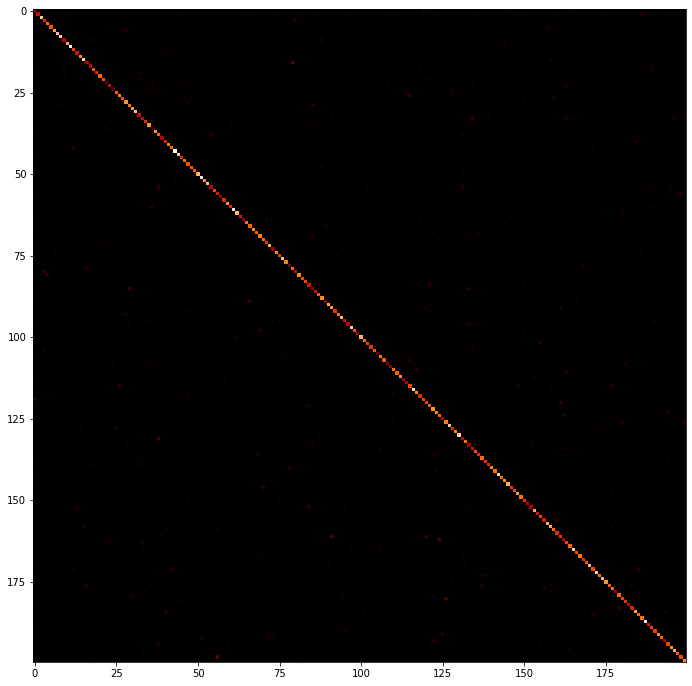

In [16]:
plt.figure(figsize=(12, 12))
plt.imshow(confusion_matrix(val_true, val_pred), cmap="gist_heat", interpolation="nearest")
plt.show()